# ANN Baseline

In [1]:
import sys

sys.path.append("..")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from einops import rearrange  # ! pip install einops

from src.dataset import ImageDataset, CLASSES
from src.utils import get_error

## Model definition

In [3]:
PATCH_SIZE = 16


def generate_positional_encoding(seq_length, dim):
    assert dim == 2 * (dim // 2)  # check if dim is divisible by 2
    pe = torch.zeros(seq_length, dim)
    position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / dim)
    )
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


class Transformer_encoder(nn.Module):
    def __init__(self, hidden_size, nb_heads):
        super(Transformer_encoder, self).__init__()
        assert hidden_size == nb_heads * (hidden_size // nb_heads)
        self.MHA = nn.MultiheadAttention(hidden_size, nb_heads)
        self.LLcat = nn.Linear(2 * hidden_size, hidden_size)
        self.LL1 = nn.Linear(hidden_size, hidden_size)
        self.LL2 = nn.Linear(hidden_size, hidden_size)
        self.LN1 = nn.LayerNorm(hidden_size)
        self.LN2 = nn.LayerNorm(hidden_size)

    def forward(self, g_seq, pos=None):
        seq_length = g_seq.size(0)
        bs = g_seq.size(1)
        pos = pos.unsqueeze(dim=1).repeat_interleave(
            bs, dim=1
        )  # size=(seq_length, bs, hidden_dim)

        h_cat = self.LLcat(
            torch.cat((g_seq, pos), dim=2)
        )  # size=(seq_length, bs, hidden_dim)

        h_MHA_seq, _ = self.MHA(h_cat, h_cat, h_cat)
        h = self.LN1(h_cat + h_MHA_seq)

        h_MLP = self.LL2(torch.relu(self.LL1(h)))  # size=(1, bs, hidden_dim)
        h_seq = self.LN2(h + h_MLP)  # size=(1, bs, hidden_dim)
        return h_seq


class MultiLabelANN(nn.Module):
    def __init__(self, hidden_size, nb_heads, no_classes):
        super(MultiLabelANN, self).__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.encoder = Transformer_encoder(hidden_size, nb_heads)
        self.LL = nn.Linear(hidden_size, no_classes)
        

    def expand_cls_to_batch(self, batch):
        """
        Args:
            batch: batch size
        Returns: cls token expanded to the batch size
        """
        return self.cls_token.expand([batch, -1, -1])

    def forward(self, img, pos=None):
        bs = img.shape[0]
        img_patches = rearrange(
            img,
            "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
            patch_x=PATCH_SIZE,
            patch_y=PATCH_SIZE,
        )

        img_patches = torch.cat((self.expand_cls_to_batch(bs), img_patches), dim=1)

        h_seq = self.encoder(img_patches, pos)
        
        score_seq = self.LL(h_seq[:, 0, :])

        return score_seq

In [4]:
BATCH_SIZE = 1
train_data = ImageDataset(train=True)
valid_data = ImageDataset(train=False)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

Number of training images: 2065
Number of test images: 365


In [5]:
### Check if inference works correctly

# nb_heads = 16
# hidden_size = 768
# no_classes = 6

# net = MultiLabelANN(hidden_size, nb_heads, no_classes)
# print(net)
# dataiter = iter(train_loader)
# images, labels = dataiter.next().values()
# seq_length = 144
# pos = generate_positional_encoding(BATCH_SIZE, 768)
# scores = net(images.view(BATCH_SIZE, 3, 144, 256), pos)
# scores.shape
# print(scores)
# scores = torch.sigmoid(scores)
# scores

In [6]:
# Used in creating data loaders as well as in train loops
N_EPOCHS = 10
LR = 0.001

NUM_HEADS = 16
HIDDEN_SIZE = 768
NUM_CLASSES = 6

### Model instantiation

In [7]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = MultiLabelANN(HIDDEN_SIZE, NUM_HEADS, NUM_CLASSES)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

### Train

In [8]:
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_err = 0.0
    model.train()

    # TRAINING ROUND
    for i, data in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # get the inputs
        inputs, labels = data.values()

        inputs = inputs.view(BATCH_SIZE, 3, 144, 256)
        inputs = inputs.to(device)
        labels = labels.to(device)

        pos = generate_positional_encoding(BATCH_SIZE, 768)
        pos = pos.to(device)

        outputs = model(inputs, pos)

        labels.squeeze_()
        outputs.squeeze_()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_err += get_error(outputs.detach(), labels, BATCH_SIZE)

    model.eval()
    print(
        "Epoch:  %d | Loss: %.4f | Train Error: %.4f"
        % (epoch, train_running_loss / i, train_err / i)
    )

Epoch:  0 | Loss: 0.5482 | Train Error: 23.5950
Epoch:  1 | Loss: 0.5233 | Train Error: 23.2477
Epoch:  2 | Loss: 0.5216 | Train Error: 23.2477
Epoch:  3 | Loss: 0.5209 | Train Error: 23.2477
Epoch:  4 | Loss: 0.5199 | Train Error: 23.2477
Epoch:  5 | Loss: 0.5193 | Train Error: 23.2477
Epoch:  6 | Loss: 0.5191 | Train Error: 23.2477
Epoch:  7 | Loss: 0.5181 | Train Error: 23.2477
Epoch:  8 | Loss: 0.5183 | Train Error: 23.2558
Epoch:  9 | Loss: 0.5176 | Train Error: 23.2477


### Test

In [9]:
test_err = 0.0
for i, data in enumerate(valid_loader, 0):
    inputs, labels = data.values()

    pos = generate_positional_encoding(BATCH_SIZE, 768)
    pos = pos.to(device)

    outputs = model(inputs.view(BATCH_SIZE, 3, 144, 256).to(device), pos)
    outputs = torch.sigmoid(outputs)
    #     print((outputs.detach() > 0.5).float(), labels)

    test_err += get_error(outputs.detach(), labels.to(device), BATCH_SIZE)

print("Validation Error: %.4f" % (test_err / i))

Validation Error: 25.4579


In [10]:
actors = np.array(CLASSES)
print("actors: ", actors)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']


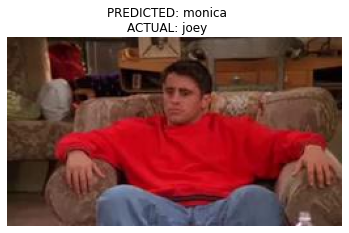

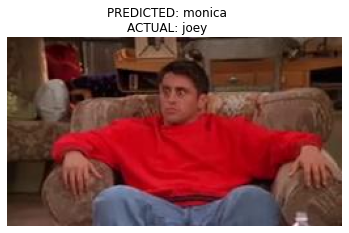

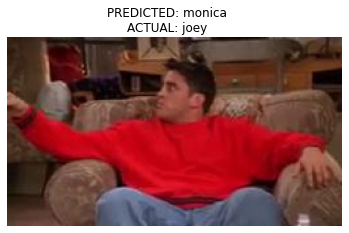

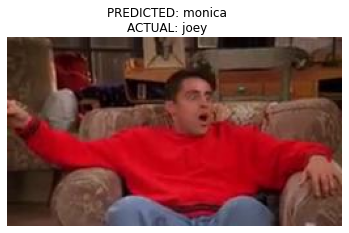

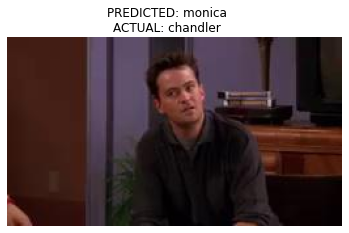

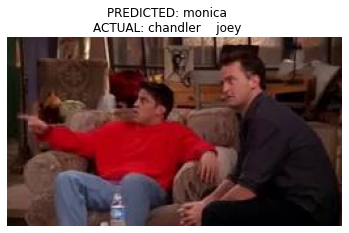

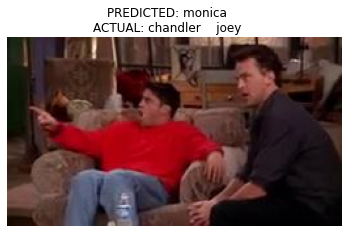

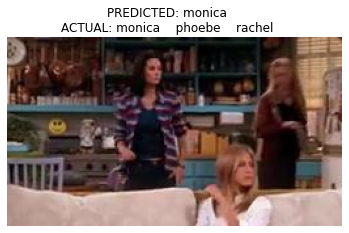

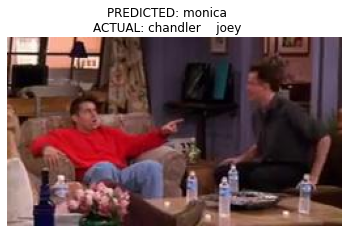

Test Error: 25.45787606920515 %


In [14]:
model.eval()
test_running_error = 0.0
output_list = []
target_list = []
for counter, data in enumerate(valid_loader):

    image, target = data["image"].to(device), data["label"]
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]

    pos = generate_positional_encoding(BATCH_SIZE, 768)

    outputs = model(image, pos.to(device))
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    lab = torch.where(outputs >= 0.3, 1, 0)[0]
    pred = torch.where(lab == 1)
    error = get_error(outputs, target, 1)

    output_list.append(outputs.numpy())
    target_list.append(target.numpy())

    test_running_error += error

    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "

    if 10 < counter < 20:
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()

test_error = test_running_error / counter
print(f"Test Error: {test_error} %")

out = np.array(output_list).squeeze(axis=1)
tar = np.array(target_list).squeeze(axis=1)